## Train custom instance segmentation model using Detectron2 - on your own dataset

**Install Detectron2**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (11118/11118), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Pre

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!pip install roboflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="8iEJD92oE4T1gY3guy9Q")
project = rf.workspace("bassem-ahmed-ouwsa").project("dentistry-vbril")
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dentistry-1 in coco:: 100%|██████████| 571/571 [00:00<00:00, 7936.15it/s]


# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/Dentistry-1/train/_annotations.coco.json", "/content/Dentistry-1/train")
register_coco_instances("my_dataset_val", {}, "/content/Dentistry-1/valid/_annotations.coco.json", "/content/Dentistry-1/valid")



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [12/30 06:00:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 06:00:26 d2.data.datasets.coco]: Loaded 452 images in COCO format from /content/Dentistry-1/train/_annotations.coco.json


In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


WARNING [12/30 06:00:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 06:00:27 d2.data.datasets.coco]: Loaded 113 images in COCO format from /content/Dentistry-1/valid/_annotations.coco.json


In [ ]:
from matplotlib import pyplot as plt

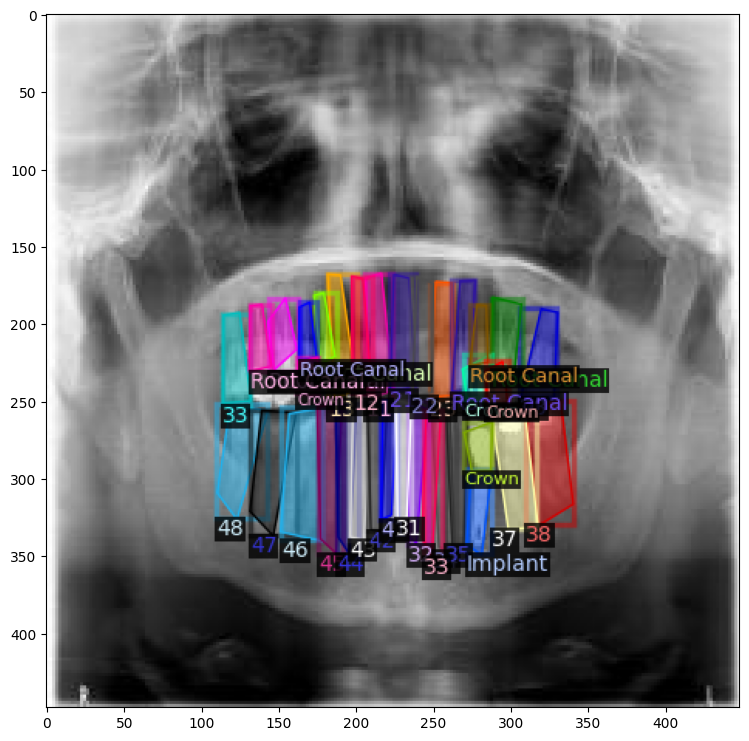

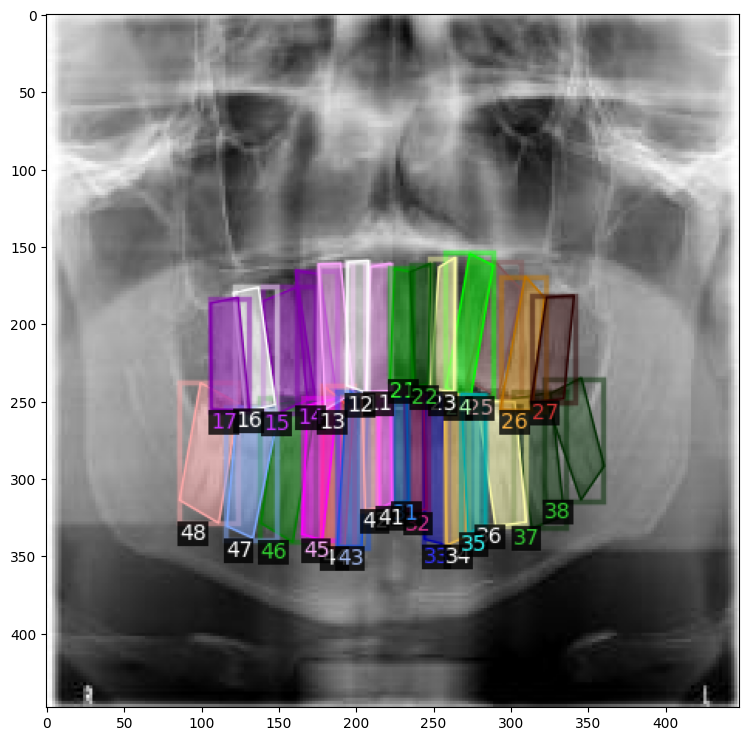

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=2)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(9,9))
    plt.imshow(vis.get_image()[:, :, ::-1])

    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.008  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 36  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[12/30 06:18:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [ ]:
# trainer.train() #Start the training process

[12/30 06:18:47 d2.engine.train_loop]: Starting training from iteration 0
[12/30 06:19:32 d2.utils.events]:  eta: 1:32:47  iter: 19  total_loss: 5.306  loss_cls: 3.413  loss_box_reg: 0.7312  loss_mask: 0.6927  loss_rpn_cls: 0.1977  loss_rpn_loc: 0.2801    time: 2.2497  last_time: 2.2752  data_time: 0.0981  last_data_time: 0.1414   lr: 0.00015985  max_mem: 12599M
[12/30 06:20:17 d2.utils.events]:  eta: 1:32:48  iter: 39  total_loss: 3.352  loss_cls: 1.506  loss_box_reg: 0.7789  loss_mask: 0.6901  loss_rpn_cls: 0.1329  loss_rpn_loc: 0.2396    time: 2.2665  last_time: 2.2978  data_time: 0.0927  last_data_time: 0.0767   lr: 0.00031969  max_mem: 12599M
[12/30 06:21:03 d2.utils.events]:  eta: 1:32:37  iter: 59  total_loss: 3.101  loss_cls: 1.306  loss_box_reg: 0.8054  loss_mask: 0.6837  loss_rpn_cls: 0.07956  loss_rpn_loc: 0.2134    time: 2.2650  last_time: 2.3212  data_time: 0.0857  last_data_time: 0.0724   lr: 0.00047953  max_mem: 12599M
[12/30 06:21:48 d2.utils.events]:  eta: 1:31:31  ite

Save the config file, for potential future use

In [ ]:
# import yaml
# # Save the configuration to a config.yaml file
# config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/config.yaml"
# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
# predictor = DefaultPredictor(cfg)

[12/30 08:00:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


Load our trained model

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/config1.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth"
predictor = DefaultPredictor(cfg)

[12/30 08:37:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


# Inference & evaluation using the trained model

Verify segmentation on random validation images

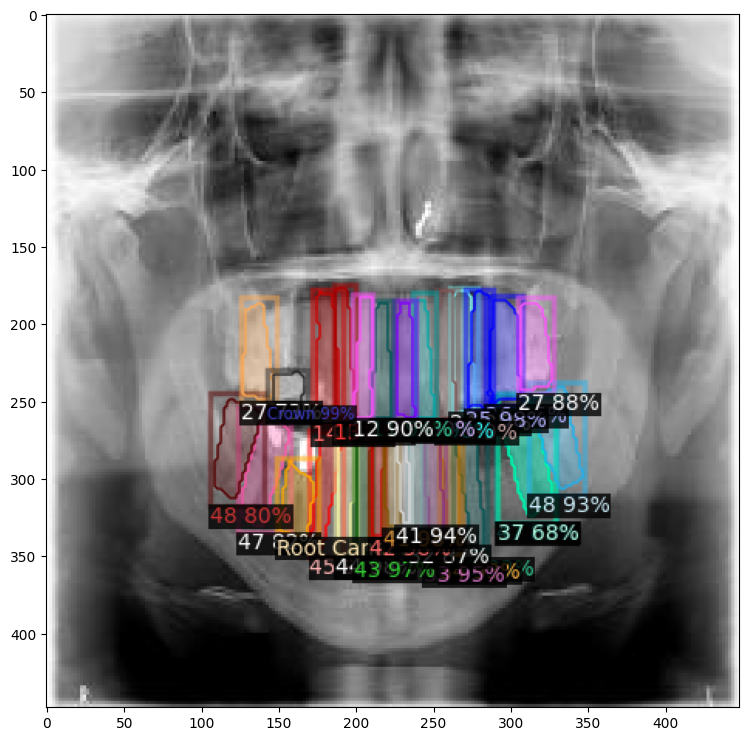

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(12,9))
    plt.imshow(out.get_image()[:, :, ::-1])

    plt.show()

In [ ]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([33, 11, 26, 28, 10, 13, 25, 29, 27, 14, 19, 12,  1, 25, 35, 20, 21, 32,
         2,  9, 15,  3, 18, 31, 31,  4, 32, 15, 23], device='cuda:0')
Boxes(tensor([[ 71.6271, 114.8472,  84.4231, 127.0882],
        [125.8933,  88.7541, 133.0084, 132.2294],
        [104.5830, 132.7429, 109.6532, 169.7234],
        [ 93.3846, 133.8659, 100.4970, 175.5678],
        [118.5883,  90.2276, 125.8421, 131.4682],
        [135.3883,  88.8485, 144.6691, 128.2066],
        [108.8650, 134.3304, 114.2370, 166.6002],
        [ 85.2458, 134.4280,  96.2124, 175.3415],
        [ 99.6712, 131.8052, 105.6928, 176.6060],
        [142.1049,  90.8742, 154.2310, 126.6601],
        [122.2070, 132.2274, 129.0588, 177.7884],
        [130.3066,  88.3524, 139.3598, 129.0933],
        [105.0096,  92.6054, 111.9684, 130.8868],
        [113.1416, 135.3522, 118.0016, 165.5722],
        [ 74.6082, 143.5980,  87.7775, 169.2634],
        [127.0889, 133.8250, 134.5285, 176.9348],
        [131.4013, 131.2072, 142.2858, 175.7

Check average precision and recall.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/30 08:01:06 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/30 08:01:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 08:01:06 d2.data.datasets.coco]: Loaded 113 images in COCO format from /content/Dentistry-1/valid/_annotations.coco.json
[12/30 08:01:07 d2.data.build]: Distribution of instances among all 36 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   tooth    | 0            |     11     | 107          |     12     | 106          |
|     13     | 102          |     14     | 98           |     15     | 89           |
|     16     | 85           |     17     | 89           |     18     | 62           |
|     21     | 106          |     22     | 108          |     23     | 106          |
|     24     | 94     

**Load a new image and segment it.**

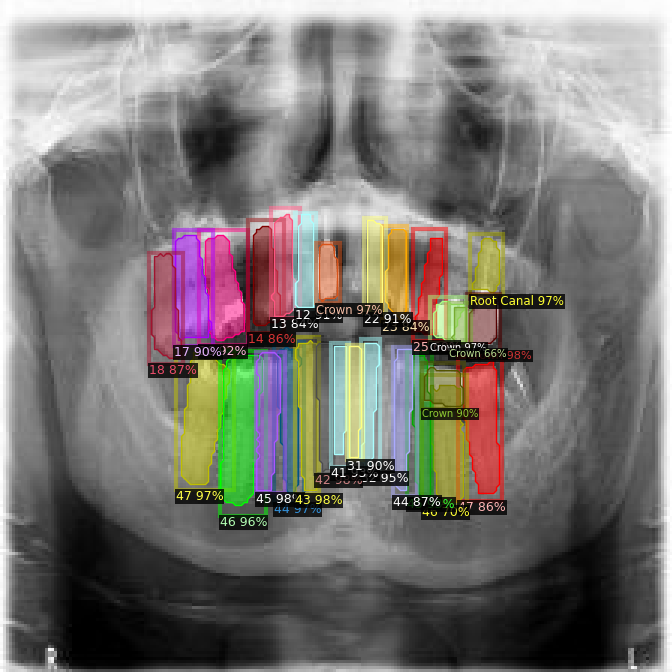

In [ ]:
new_im = cv2.imread("/content/Dentistry-1/valid/0000036_png_jpg.rf.f9ed8b713373acc646f0b4f39cbad598.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata,scale = 3)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])
